# A Teaser Example

In [598]:
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from clu import parameter_overview
import optax

import matplotlib
%matplotlib inline
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt

C:\Users\rouss\AppData\Local\Temp\ipykernel_20736\4219119754.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


## Supervised learning

In [599]:
## X-data
N = 200
X = np.random.random((N,1))
X.shape

(200, 1)

In [600]:
## Y data
sign = (- np.ones((N,))) ** np.random.randint(2, size=N)
Y = np.sqrt(X[:,0]) * sign
Y.shape

(200,)

In [601]:
## Neural Net
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10)(x)        ## Can be jitted with nn.jit
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        # x = nn.linear(x)
        return x

nn_sv = NN()
key = jax.random.PRNGKey(0)
init_data = jnp.ones((2,1))
params = nn_sv.init(key, init_data)
print(nn_sv.tabulate(key, init_data))

                     NN Summary                     
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[2,1]  │                        │
├─────────┼───────────────┼────────────────────────┤
│ Dense_0 │ float32[2,10] │ bias: float32[10]      │
│         │               │ kernel: float32[1,10]  │
│         │               │                        │
│         │               │ 20 (80 B)              │
├─────────┼───────────────┼────────────────────────┤
│ Dense_1 │ float32[2,10] │ bias: float32[10]      │
│         │               │ kernel: float32[10,10] │
│         │               │                        │
│         │               │ 110 (440 B)            │
├─────────┼───────────────┼────────────────────────┤
│ Dense_2 │ float32[2,1]  │ bias: float32[1]       │
│         │               │ kernel: float32[10,1]  │
│         │               │                        │
│         │               │ 11 (44 B)              │
├─────────┼───────────────┼────────────────────────┤
│ NN      │ float32[2,1]  │                        │
├─────────┼───────────────┼────────────────────────┤
│         │         Total │ 141 (564 B)            │
└─────────┴───────────────┴────────────────────────┘
                                                    
           Total Parameters: 141 (564 B)            

In [602]:
## Data generator
def get_batch_data(X, Y, batch_size):
    size = X.shape[0]
    i = 0
    while i < size:
        inext = i + batch_size
        if inext > size: inext = size
        yield X[i:inext], Y[i:inext]
        i = inext

## Optimizer
optimizer_sv = optax.adam(learning_rate=1e-3)
opt_state = optimizer_sv.init(params=params)

## Loss function
@jax.jit
def loss_sv(params, x, y):
    ypred = nn_sv.apply(params, x).flatten()
    loss = (ypred - y)**2
    # loss = optax.l2_loss(ypred, y)
    return jnp.mean(loss)

In [603]:
## Parameter update step. Maximum jittable block 
@jax.jit
def update_params(opt_state, params, x, y):
    grads = jax.grad(loss_sv)(params, x, y)
    updates, opt_state = optimizer_sv.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

## Training loop
loss_data_sv = []
for epoch in range(5):
    for x, y in get_batch_data(X, Y, batch_size=5):
        opt_state, params = update_params(opt_state, params, x, y)
    loss_data_sv.append(loss_sv(params, x,y))


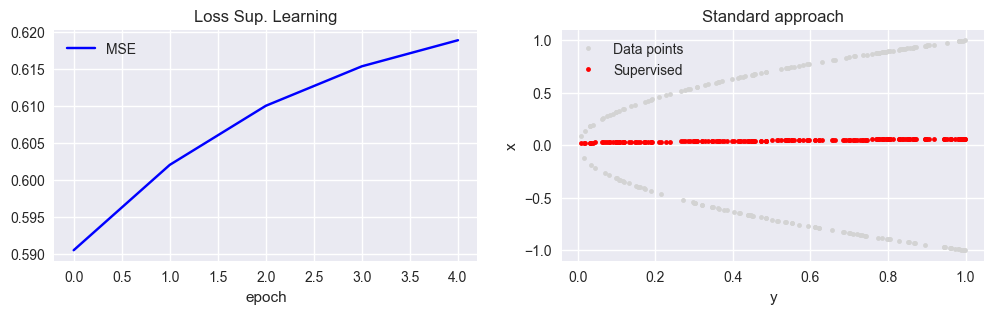

In [604]:
## Wrapper function for matplotlib
def plot(*args, axis=None, x_label=None, y_label=None, title=None, **kwargs):
    if axis==None:
        _, axis = plt.subplots(1, 1, figsize=(6,3))
    if x_label:
        axis.set_xlabel(x_label)
    if y_label:
        axis.set_ylabel(y_label)
    if title:
        axis.set_title(title)
    axis.plot(*args, **kwargs)
    axis.legend()
    return axis

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6*2, 3))
ax1 = plot(loss_data_sv, '-', color="blue", x_label="epoch", label="MSE", title="Loss Sup. Learning", axis=ax1)
ax2 = plot(X, Y, '.', label='Data points', color="lightgray", x_label="y", y_label="x", title="Standard approach", axis=ax2)
ax2 = plot(X, nn_sv.apply(params, X), '.', label='Supervised', color="red", axis=ax2)

## Differentiable physics approach

In [605]:
nn_dp = NN()
key = jax.random.PRNGKey(0)
params = nn_dp.init(key, init_data)
print(nn_dp.tabulate(key, init_data))

                     NN Summary                     
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[2,1]  │                        │
├─────────┼───────────────┼────────────────────────┤
│ Dense_0 │ float32[2,10] │ bias: float32[10]      │
│         │               │ kernel: float32[1,10]  │
│         │               │                        │
│         │               │ 20 (80 B)              │
├─────────┼───────────────┼────────────────────────┤
│ Dense_1 │ float32[2,10] │ bias: float32[10]      │
│         │               │ kernel: float32[10,10] │
│         │               │                        │
│         │               │ 110 (440 B)            │
├─────────┼───────────────┼────────────────────────┤
│ Dense_2 │ float32[2,1]  │ bias: float32[1]       │
│         │               │ kernel: float32[10,1]  │
│         │               │                        │
│         │               │ 11 (44 B)              │
├─────────┼───────────────┼────────────────────────┤
│ NN      │ float32[2,1]  │                        │
├─────────┼───────────────┼────────────────────────┤
│         │         Total │ 141 (564 B)            │
└─────────┴───────────────┴────────────────────────┘
                                                    
           Total Parameters: 141 (564 B)            

In [606]:

## Optimizer
optimizer_dp = optax.adam(learning_rate=1e-3)
opt_state = optimizer_dp.init(params=params)

## Loss function
@jax.jit
def loss_dp(params, x, y):
    ypred = nn_sv.apply(params, x)
    loss = (ypred**2 - y)**2
    # loss = optax.l2_loss(ypred**2, y)
    return jnp.mean(loss)

## Parameter update step. Maximum jittable block 
@jax.jit
def update_params(opt_state, params, x, y):
    grads = jax.grad(loss_dp)(params, x, y)
    updates, opt_state = optimizer_dp.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

## Training loop
loss_data_dp = []
for epoch in range(5):
    for x, y in get_batch_data(X, Y, batch_size=5):
        opt_state, params = update_params(opt_state, params, x, x)
    loss_data_dp.append(loss_dp(params, x, x))

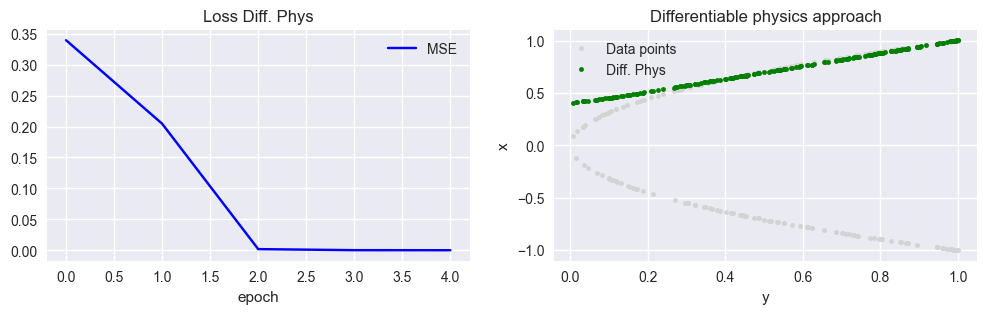

In [607]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6*2, 3))
ax1 = plot(loss_data_dp, '-', color="blue", x_label="epoch", label="MSE", title="Loss Diff. Phys", axis=ax1)
ax2 = plot(X, Y, '.', label='Data points', color="lightgray", x_label="y", y_label="x", title="Differentiable physics approach", axis=ax2)
ax2 = plot(X, nn_dp.apply(params, X), '.', label='Diff. Phys', color="green", axis=ax2)